# LSTM with Numpy

In [2]:
import numpy as np

#### Initializing

Here H is the number of LSTM neurons. X_size is the size of the data so if it was a poem or letters it is going to be the number of characters. Z is the input plus what the LSTM layer already knows.


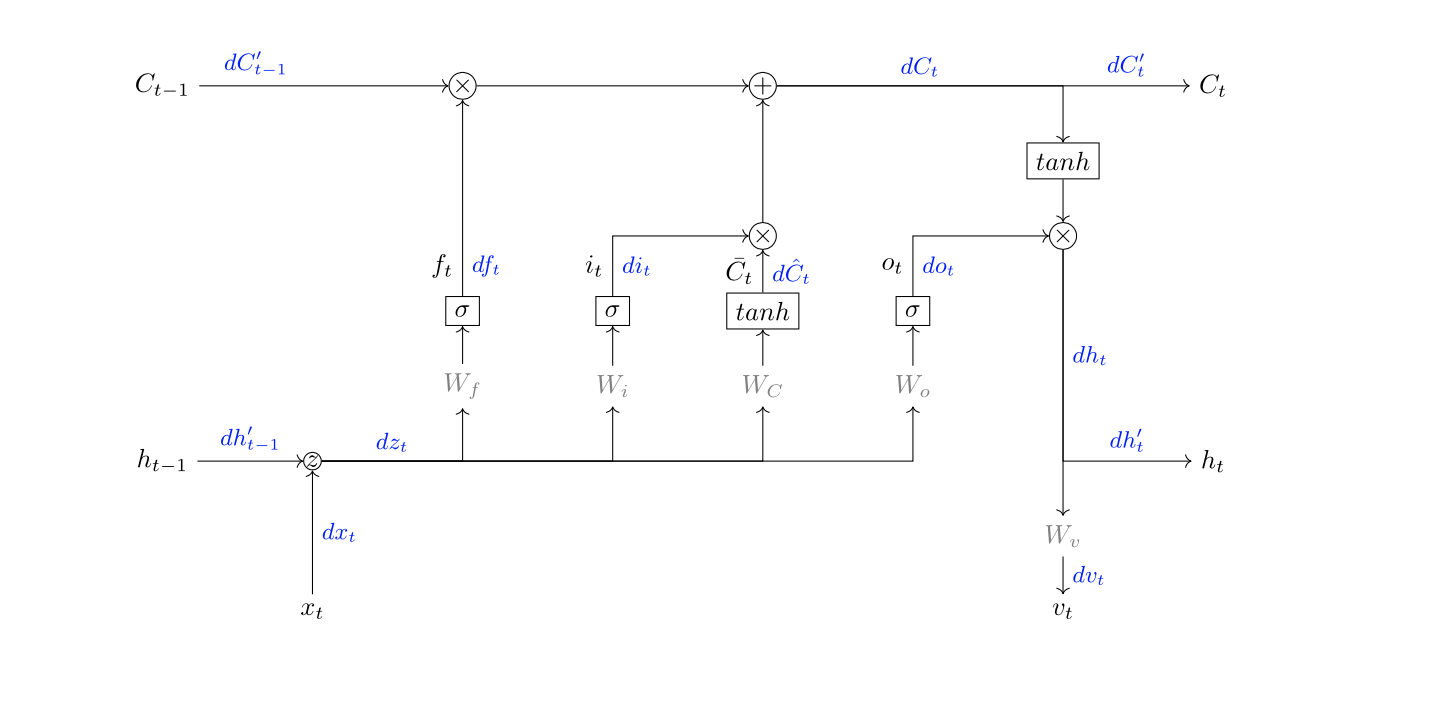

In [15]:
H = 128 # Number of LSTM layer's neurons
X_size =3
D = X_size # Number of input dimension == number of items in vocabulary
Z = H + D # Because we will concatenate LSTM state with the input

model = dict(
    W_f=np.random.randn(Z, H) / np.sqrt(Z / 2.),    #
    W_i=np.random.randn(Z, H) / np.sqrt(Z / 2.),
    W_c=np.random.randn(Z, H) / np.sqrt(Z / 2.),
    W_o=np.random.randn(Z, H) / np.sqrt(Z / 2.),
    W_v=np.random.randn(H, D) / np.sqrt(D / 2.),
    b_f=np.zeros((1, H)),
    b_i=np.zeros((1, H)),
    b_c=np.zeros((1, H)),
    b_o=np.zeros((1, H)),
    b_v=np.zeros((1, D))
)

#### Making Functions

These are functions for the sigmoid and tanh functions that will be used inside the LSTM cell.

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def dsigmoid(y):
    return y * (1 - y)


def tanh(x):
    return np.tanh(x)


def dtanh(y):
    return 1 - y * y

#### LSTM Forward Pass

So, following the picture above, we first take our model and pull the weights and biases for this cell. Next, state contains the previous cells h and c. I do not understand what the purpose of the one hot encoding is. Next, run the three sigmoid functions with their respective inputs and the one tanh function. This now gives us hf, hi, ho, and hc which we can multiply and add using the equation for c to get the new c. Lastly, we turn that into h and we are on our way to the next cell.

In [ ]:
def lstm_forward(X, state):
    m = model
    Wf, Wi, Wc, Wo, Wv = m['Wf'], m['Wi'], m['Wc'], m['Wo'], m['Wv']  #Pulls out all weights
    bf, bi, bc, bo, bv = m['bf'], m['bi'], m['bc'], m['bo'], m['bv']   #Pulls out all biases

    h_old, c_old = state    #Previous cell state

    # One-hot encode
    X_one_hot = np.zeros(D)
    X_one_hot[X] = 1.
    X_one_hot = X_one_hot.reshape(1, -1)

    # Concatenate old state with current input
    X = np.column_stack((h_old, X_one_hot))

    hf = sigmoid(X * Wf + bf)
    hi = sigmoid(X * Wi + bi)
    ho = sigmoid(X * Wo + bo)
    hc = tanh(X * Wc + bc)

    c = hf * c_old + hi * hc
    h = ho * tanh(c)

    y = h * Wv + bv
    prob = softmax(y)

    state = (h, c) # Cache the states of current h & c for next iter
    cache = 0 # Add all intermediate variables to this cache

    return prob, state, cache

This is from the link https://wiseodd.github.io/techblog/2016/08/12/lstm-backprop/. I want to walk through the back propogation because I do not really understand it all that well. Maybe that is why they use the one hot encoding.

### Backward Pass Pseudo Code


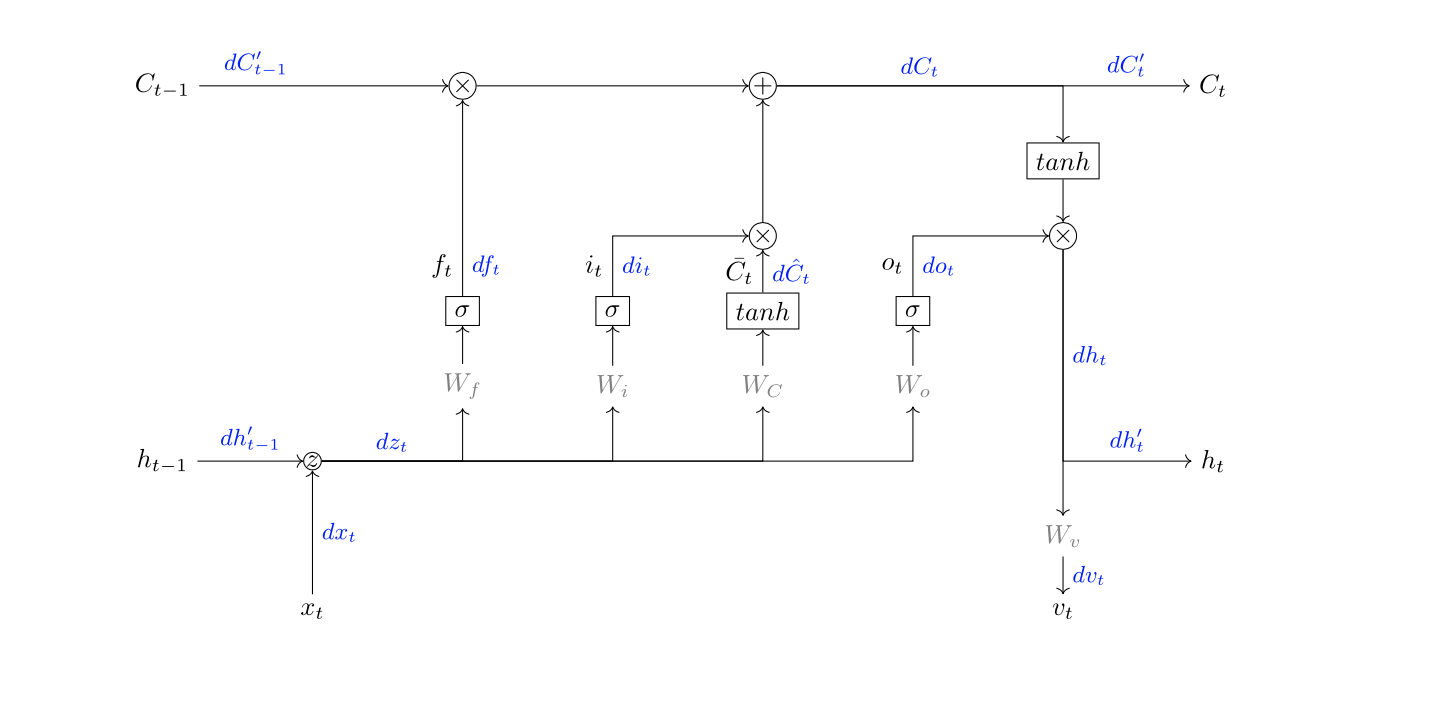

E_delta=(y-h)      This is dE/dht or the original value minus the predicted value

**Next we want to find output gate**

dE/do = (dE/dht ) * (dht /do) = dE/do =  E_delta * tanh(ct)

dE/dct = (dE / dht )*(dht /dct) = dE/dct  =   E_delta   * o * dtanh(ct) 

**Next we go onto the inside of the LSTM with respect to ct**

dE/dC_hat =  E_delta   * o * dtanh(ct) * i 

**Forget Gate**

dE/df =  E_delta   * o * dtanh(ct) *  ct-1 

**Next we go onto the inside of the LSTM with respect to ct-1**

dE/dct =  E_delta   * o * dtanh(ct) * f  

Using this now we can update the weights


**Gradient with respect to output gate weights:**
    
dE/dwxo   =  dE/do *(do/dwxo) = E_delta * tanh(ct) * dsigmoid(zo) * xt

dE/dwho   =  dE/do *(do/dwho) = E_delta * tanh(ct) * dsigmoid(zo) * ht-1

dE/dbo   =  dE/do *(do/dbo) = E_delta * tanh(ct) * dsigmoid(zo)



**Gradient with respect to forget gate weights:**
    
dE/dwxf  =  dE/df *(df/dwxf) = E_delta * o * dtanh(ct) * ct-1 * dsigmoid(zf) * xt

dE/dwhf =  dE/df *(df/dwhf) = E_delta * o * dtanh(ct) *  ct-1 * dsigmoid(zf) * ht-1

dE/dbo  =  dE/df *(df/dbo) = E_delta * o * dtanh(ct) *  ct-1 * dsigmoid(zf)


**Gradient with respect to input gate weights:**
    
dE/dwxi  =  dE/di *(di/dwxi) = E_delta * o * dtanh(ct) * g * dsigmoid(zi) * xt

dE/dwhi =  dE/di *(di/dwhi) = E_delta * o * dtanh(ct) * g * dsigmoid(zi) * ht-1

dE/dbi  =  dE/di *(di/dbi) = E_delta * o * dtanh(ct) * g *  dsigmoid(zi)

dE/dwxC_hat  =  dE/dC_hat *(dC_hat/dwxC_hat) = E_delta * o * dtanh(ct) * i * dtanh(zg)*xt

dE/dwhC_hat  =  dE/dC_hat *(dC_hat/dwhC_hat) = E_delta * o * dtanh(ct) * i * dtanh(zg)*ht-1

dE/dbC_hat  =  dE/dC_hat *(dC_hat/dbC_hat)  = E_delta * o * dtanh(ct) * i * dtanh(zg)

**Laslty we update thje weights using the equation New Weight = old + learning rate * derivative.**